# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [4]:
# Configure API key 

quandl.ApiConfig.api_key = 'qwUf4jsuxF2y1pPATidA'

In [5]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('FRED/PCU4412224412221')

In [6]:
data.head(5)

,Value
Date,
2001-06-01,100.0
2001-07-01,98.2
2001-08-01,98.8
2001-09-01,101.5
2001-10-01,101.1


In [7]:
data.shape

(247, 1)

In [8]:
data.columns

Index(['Value'], dtype='object')

In [9]:
type(data)

pandas.core.frame.DataFrame

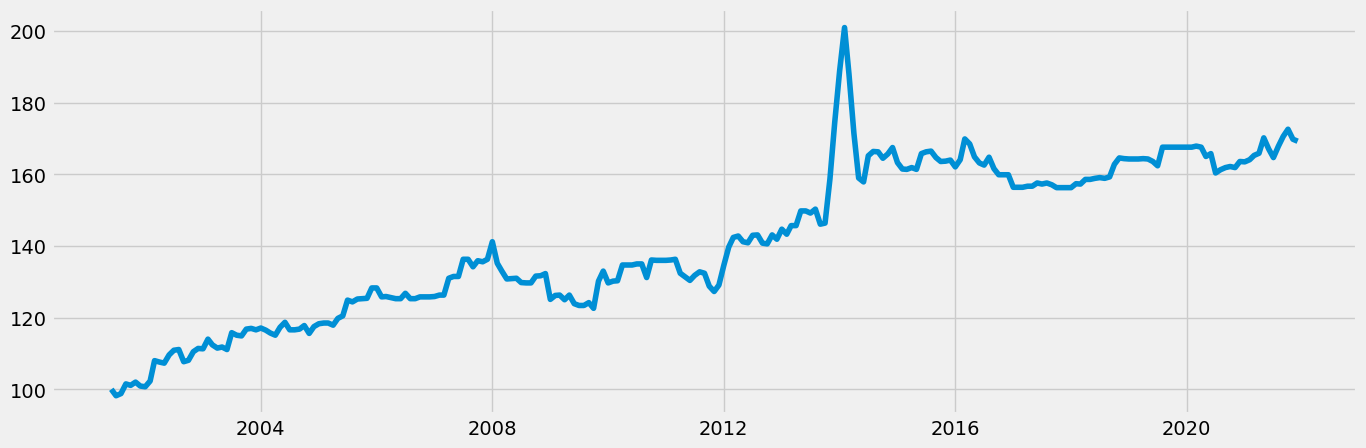

In [13]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [14]:
# Check for missing values (you shouldn't have any)

data.isnull().sum() 

Value    0
dtype: int64

In [15]:
# Check for duplicates

dups = data.duplicated()
dups.sum()

70

In [30]:
# Dropping duplicates
data_clean = data.drop_duplicates()

In [31]:
# Checking new data
data_clean.shape

(177, 1)

In [39]:
data_clean.head()

,Value
Date,
2001-06-01,100.0
2001-07-01,98.2
2001-08-01,98.8
2001-09-01,101.5
2001-10-01,101.1


### 3. Time-series analysis: decomposition

In [44]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data, model='additive')

In [45]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

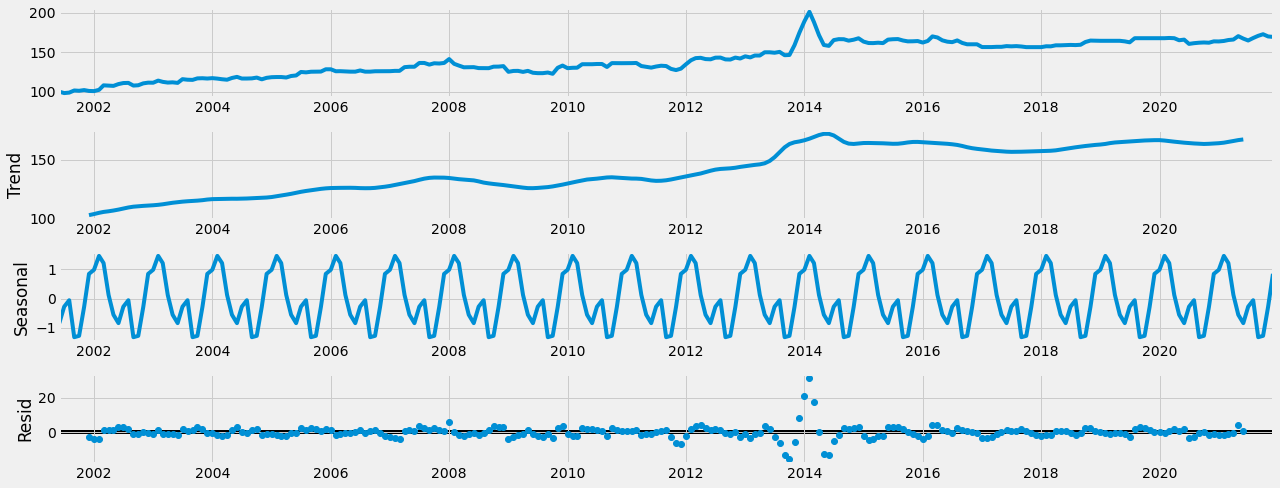

In [46]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Analyze the results from the plot in a markdown cell

The chart shows the trend line of boat sales which is increasing throughout the years and its seasonality. We can see there is not much unexplained noise apart from the period of time around 2014.

### 4. Testing for stationarity

In [47]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.515421
p-value                          0.525869
Number of Lags Used              4.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


#### Interpret the results in a markdown cell and reference your null hypothesis.

The test statistic is larger than the critical value which means we can’t reject null hypothesis, the data is non-stationary. 

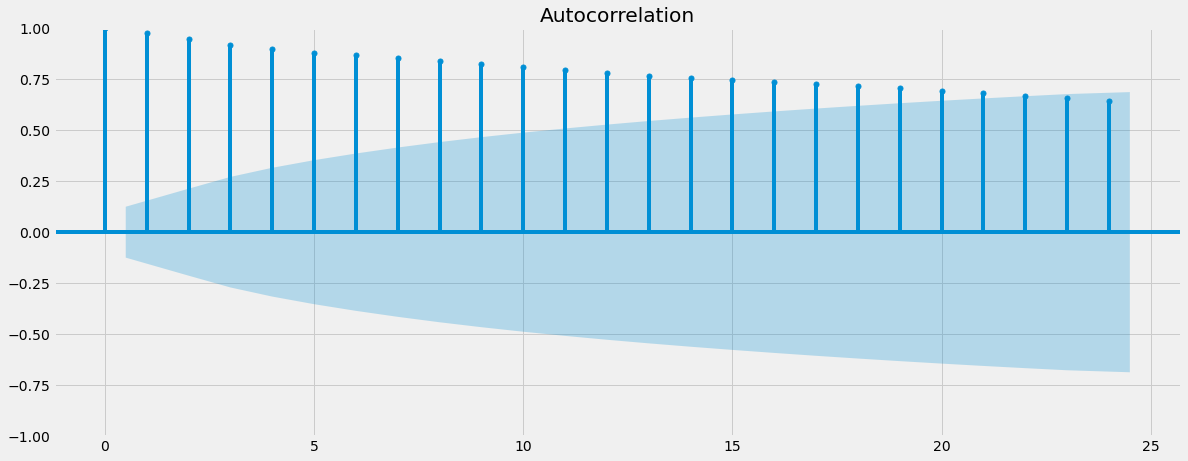

In [48]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data)
plt.show()

### 5. Stationarizing the Federal Reserve Economic Data

In [80]:
data_diff = data - data.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [81]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [82]:
data_diff.head()

,Value
Date,
2001-07-01,-1.8
2001-08-01,0.6
2001-09-01,2.7
2001-10-01,-0.4
2001-11-01,0.9


In [83]:
data_diff.columns

Index(['Value'], dtype='object')

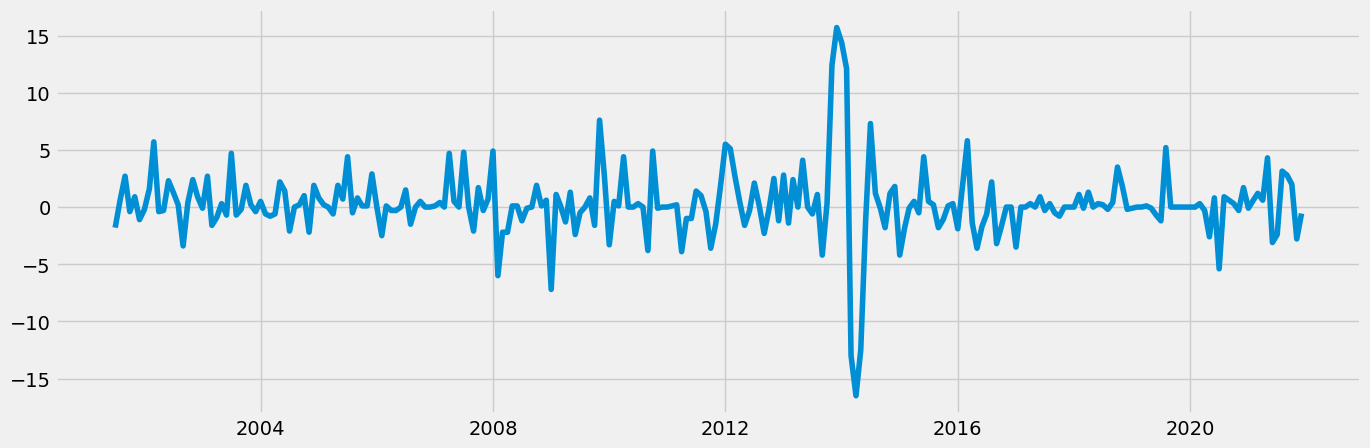

In [84]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [85]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.083081e+01
p-value                        1.710110e-19
Number of Lags Used            3.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


The data is still non stationary as the test statistic is still larger than the critcial value, we must conduct another round of differencing.

In [88]:
# second round of differencing
data_diff = data_diff - data_diff.shift(1)

In [89]:
data_diff.dropna(inplace = True)

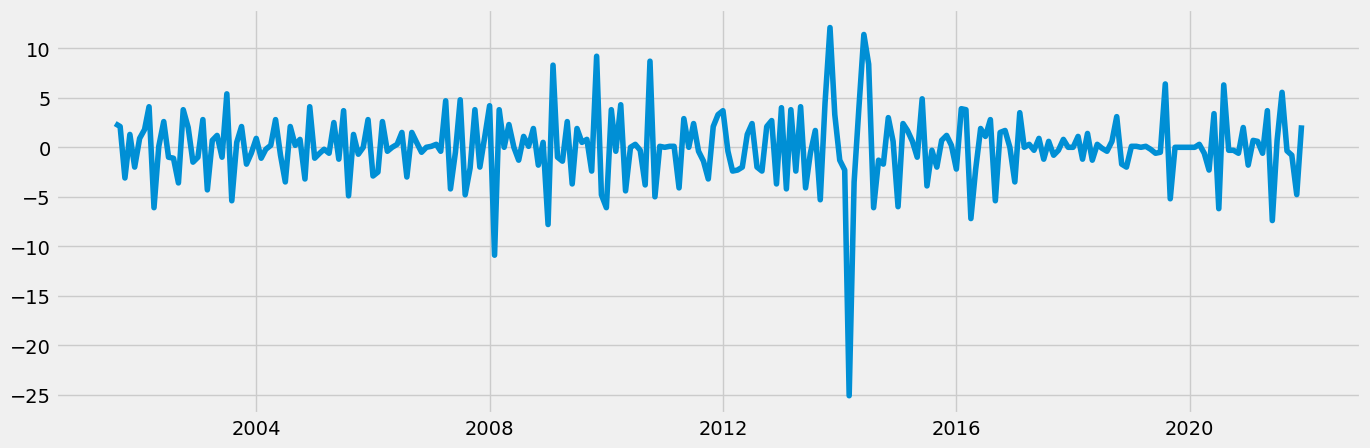

In [90]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [91]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.455056e+00
p-value                        1.490546e-08
Number of Lags Used            1.600000e+01
Number of Observations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+00
Critical Value (10%)          -2.573571e+00
dtype: float64


The test statistic is now smaller that the critical value which means we CAN reject the null hypothesis and the data is stationarity.

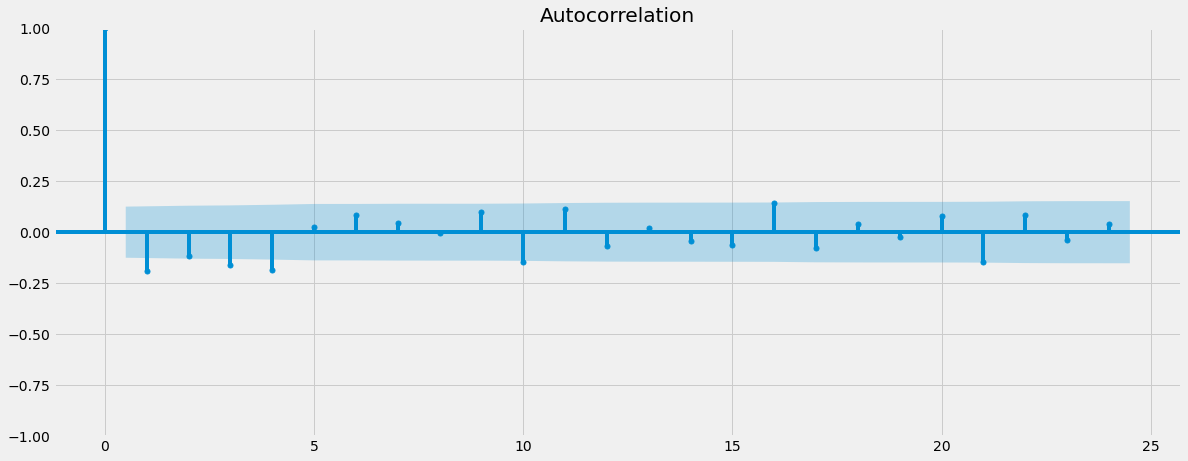

In [92]:
plot_acf(data_diff)
plt.show()